

<p align="center">
  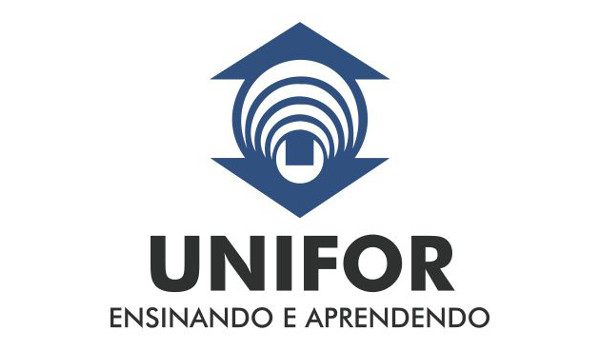</p>
<h1 style='text-align: center;'>UNIFOR - Universidade de Fortaleza</h1>
<h2 style='text-align: center;'>MBA EM CIÊCIA DE DADOS - Engenharia de Dados </h2>
<h4 style='text-align: center;'>PROF. Manoel Ribeiro </h4>
<h4 style='text-align: center;'>JOSÉ VALCLEMIR RODRIGUES DA SILVA</h4>
<br><br>
<h4 style='text-align: center;'>Fortaleza-Ceará</h4>



### 1. Importando bibliotecas

In [195]:

from sklearn.linear_model import LinearRegression
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from warnings import simplefilter
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
simplefilter("ignore")

### 2. Ler e transforma os dados

In [202]:
c = MongoClient("mongodb://192.168.1.64")
db = c['bigdata']

covid = db['covid']
filtro = {"location": "Brazil"}
lista = []
try: 
    for doc in covid.find(filtro):
        dados = {}
        dados['populacao'] = doc['population']
        dados['populacao_total_vacinada'] = doc['people_fully_vaccinated']
        dados['date'] = doc['date']
        lista.append(dados)
    df = pd.DataFrame(lista)
    df = df.sort_values('date')
    
    people_fully_vaccinated = []
    for i in df['populacao_total_vacinada']: 
        if i == '':
            i = 0
        else:
            i = i.split('.')[0]

        people_fully_vaccinated.append(int(i))
    df['populacao_total_vacinada'] = people_fully_vaccinated
    
    
    population = []
    for i in df['populacao']: 
        i = i.split('.')[0]

        population.append(int(i))
    df['populacao'] = population
    
except:
    df = pd.read_csv('dadoscovid-v2.csv')
    df['populacao'] = df['population']
    df['populacao_total_vacinada'] = df['people_fully_vaccinated'].fillna(0)
    df = df[df['location'] == 'Brazil']
        
# pega todo mundo desde o inicio da vacinacao
min_date = df.date[df['populacao_total_vacinada'] > 0].min()
df = df[df.date >= min_date]
df['date'] = pd.to_datetime(df['date'])
df['dias'] = pd.Series(df['date'] - df['date'].min()).dt.days.values.reshape(-1, 1)     

### 3. Agrupa os dados e pega o ultimo report da população vacinada

In [203]:
d = df[['populacao', 'populacao_total_vacinada', 'date']].groupby(['populacao', 'date']).max().reset_index().sort_values('date')

### 4. Retira os dados onde seja igual a 0
#### Como os dados da população totalmente vacinada segue uma linha continua de crescimento, o ideal será retirar os 0.

In [204]:
df = df[df['populacao_total_vacinada'] > 0]
X_ = pd.Series(df['date'] - df['date'].min()).dt.days.values.reshape(-1, 1)
Y_ = df.populacao_total_vacinada.values

### 5. Treina o modelo e avalia

In [205]:
reg = LinearRegression().fit(X_, Y_)
score = reg.score(X_, Y_)
mae = mean_absolute_error(Y_, reg.predict(X_))
print("Score:", round(score * 100, 2), "  Mae:", mae)

Score: 95.01   Mae: 2659529.2043425418


#### Modelo treinado. 
1. Acima podemos ver que o modelo atingiu um score de 95%, ou seja, isso indica que o modelo se adequou bastante aos nossos dados de treinamento. 
2. Já o MAE ou o erro médio absoluto, indica um erro entre as observações, no caso, meus valores originais e os preditos.

### 6. Cria um dataframe para salvar o resultado da regressão

In [206]:
df_reg = pd.DataFrame()
df_reg['dias'] = X_.reshape(len(X_)) 
df_reg['total_vacinados'] = Y_ 
df_reg['taxa'] = Y_ / df['populacao'].values[0]

### 7. Plota a regressão

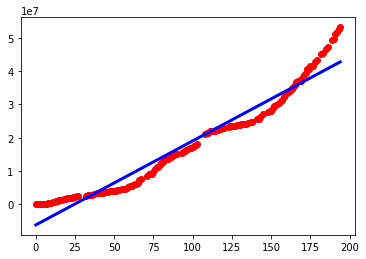

In [210]:
plt.scatter(X_, Y_,  color='red')
plt.plot(X_, reg.predict(X_), color='blue', linewidth=3)

#### Podemos observar que os dados eventualmente se adequam aos dados. Um outro teste que poderiamos fazer, seria o teste de homocedasticidade, pra vermos se ao longo do tempo, os dados iriam permanecer em torno da linha de regressão ou se iriam se dispersar.

### 8. Faz as estimativas

In [207]:
pred_taxa = 0 
dados = {}
arr = []
dia = df['dias'].values.max()
df_final = pd.DataFrame() 
while pred_taxa < 100:
    x = np.array([dia]).reshape(-1, 1)
    pred = reg.predict(x)[0]
    pred_taxa += pred / df['population'].values[0]
    
    dados = {'dias': dia, 'total_vacinados': pred, 'taxa': pred_taxa}
    dia = dia + 1
    arr.append(dados)
    print("Dia :", dia, "Total vacinados :",pred, "Taxa :", pred_taxa)
    
df_estimativa = pd.DataFrame(arr)


Dia : 195 Total vacinados : 42796959.05780651 Taxa : 0.20134116508484698
Dia : 196 Total vacinados : 43049818.20386484 Taxa : 0.4038719229863466
Dia : 197 Total vacinados : 43302677.34992318 Taxa : 0.607592273704499
Dia : 198 Total vacinados : 43555536.4959815 Taxa : 0.8125022172393039
Dia : 199 Total vacinados : 43808395.642039835 Taxa : 1.0186017535907614
Dia : 200 Total vacinados : 44061254.78809816 Taxa : 1.2258908827588715
Dia : 201 Total vacinados : 44314113.93415649 Taxa : 1.4343696047436343
Dia : 202 Total vacinados : 44566973.08021483 Taxa : 1.6440379195450499
Dia : 203 Total vacinados : 44819832.22627315 Taxa : 1.854895827163118
Dia : 204 Total vacinados : 45072691.372331485 Taxa : 2.066943327597839
Dia : 205 Total vacinados : 45325550.51838982 Taxa : 2.280180420849212
Dia : 206 Total vacinados : 45578409.66444814 Taxa : 2.494607106917238
Dia : 207 Total vacinados : 45831268.81050648 Taxa : 2.7102233858019167
Dia : 208 Total vacinados : 46084127.9565648 Taxa : 2.9270292575032

Dia : 329 Total vacinados : 76680084.62962277 Taxa : 37.940924313077474
Dia : 330 Total vacinados : 76932943.77568111 Taxa : 38.302860508410426
Dia : 331 Total vacinados : 77185802.92173944 Taxa : 38.66598629656003
Dia : 332 Total vacinados : 77438662.06779777 Taxa : 39.03030167752629
Dia : 333 Total vacinados : 77691521.2138561 Taxa : 39.3958066513092
Dia : 334 Total vacinados : 77944380.35991442 Taxa : 39.76250121790876
Dia : 335 Total vacinados : 78197239.50597276 Taxa : 40.13038537732498
Dia : 336 Total vacinados : 78450098.6520311 Taxa : 40.49945912955785
Dia : 337 Total vacinados : 78702957.79808941 Taxa : 40.86972247460737
Dia : 338 Total vacinados : 78955816.94414775 Taxa : 41.241175412473545
Dia : 339 Total vacinados : 79208676.09020609 Taxa : 41.61381794315637
Dia : 340 Total vacinados : 79461535.23626441 Taxa : 41.98765006665585
Dia : 341 Total vacinados : 79714394.38232274 Taxa : 42.36267178297199
Dia : 342 Total vacinados : 79967253.52838106 Taxa : 42.73888309210477
Dia : 

### 8. Concatena os dataframes. 

In [208]:
df_final = pd.concat([df_reg, df_estimativa])

In [209]:
df_final

,dias,total_vacinados,taxa
0,0,1.962000e+03,0.000009
1,1,1.967700e+04,0.000093
2,2,2.568800e+04,0.000121
3,3,3.361600e+04,0.000158
4,4,5.065500e+04,0.000238
...,...,...,...
270,464,1.110689e+08,98.084709
271,465,1.113218e+08,98.608430
272,466,1.115746e+08,99.133340
273,467,1.118275e+08,99.659440


In [243]:
df_final[ (df_final['taxa'] >= 43.0) & (df_final['taxa'] <= 43.99) ].sort_values('taxa').head(1)

,dias,total_vacinados,taxa,IsEstimado
148,342,8.022011e+07,43.116284,1.0


#### Podemos observar que com 342 dias, após a data base, atingiriamos 43% dos imunizados.

In [224]:
df_final[ (df_final['taxa'] >= 60.0) & (df_final['taxa'] <= 60.99) ].sort_values('taxa').head(1)

,dias,total_vacinados,taxa
190,384,9.084020e+07,60.041324


#### Podemos observar que com 384 dias, após a data base, atingiriamos 60% dos imunizados.

In [225]:
df_final[ (df_final['taxa'] >= 100.0) & (df_final['taxa'] <= 100.99) ].sort_values('taxa').head(1)

,dias,total_vacinados,taxa
274,468,1.120804e+08,100.18673


#### Podemos observar que com 468 dias, após a data base, atingiriamos 100% dos imunizados.

### 9. Plota os dados reais, mais a linha de estimativas.

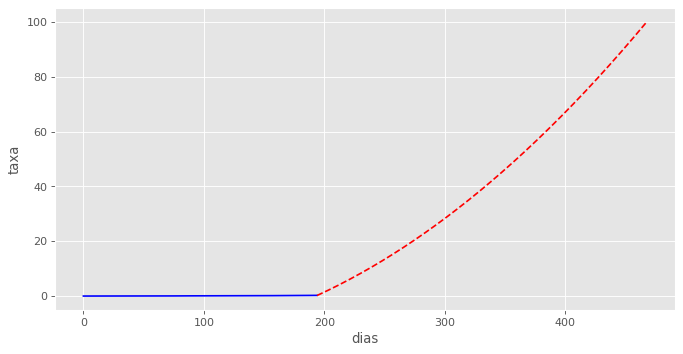

In [235]:
plt.figure(figsize=(10, 5), dpi=80)
columns = ['dias', 'taxa']
with plt.style.context('ggplot'):
    plt.plot(df_reg.set_index('dias').taxa, color="blue") 
    plt.plot(df_estimativa['dias'], df_estimativa['taxa'], color="red", linestyle='dashed')
    plt.xlabel("dias")
    plt.ylabel("taxa")


In [236]:
#df_final.loc[(df_final['dias'] >= 0) & (df_final['dias'] <= df_reg['dias'].max() ), 'IsEstimado'] = 0
#df_final.loc[ df_final['dias'] >= df_reg['dias'].max(), "IsEstimado"] = 1

#import plotly.express as px
#fig = px.line(df_final, x="dias", y="taxa", color="IsEstimado")
#fig.update_traces(textposition="bottom right")
#fig.show()

In [242]:
lista_paises = ['Africa','Asia','Europe',
                 'European Union','North America',
                 'Oceania','South America','World']
df[~df['location'].isin(lista_paises)]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality,populacao,populacao_total_vacinada,dias


### 10. FIM